In [1]:
import os
from zipfile import ZipFile
import pandas as pd
import json
import numpy as np
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [2]:
# DELETE FOLDER CREATED
def delete_folder_raw(folder_to_delete):
    print(folder_to_delete)
    shutil.rmtree(folder_to_delete)

In [3]:
def extract_json_data(filename, meta=False):
    separador = os.path.sep
    dir_actual = os.getcwd()
    execution_folder_dir = separador.join(dir_actual.split(separador)[:-1])
    folder_json = os.path.join(execution_folder_dir, "1_Datos", filename)
    path_to_extract = os.path.join(execution_folder_dir, "1_Datos")
    
    if not os.path.exists(folder_json[:-4]):
        print("folder_json: {}".format(folder_json))
        with ZipFile(folder_json, 'r') as f:
            f.extractall(path_to_extract)
        delete_folder_raw(folder_json)
    folder_json = folder_json[:-4]
    file_json = os.listdir(folder_json)[0]
    return separador.join([folder_json, file_json])


In [4]:
import pandas as pd
a = pd.DataFrame.from_records([{"a": True, "b": 2},{"a": False, "b": 3}])
print(a.head())

       a  b
0   True  2
1  False  3


In [5]:
def open_json_file(raw_name, meta = False):
    csv_filename = "meta.csv" if meta else "interactions.csv"
    print("csv_filename: {}".format(csv_filename))
    if not os.path.exists(os.path.join(os.getcwd(), csv_filename)):
        data = []
        file_json = extract_json_data(raw_name)
        with open(file_json, "r") as f:
            for line in f.readlines():
                data.append(json.loads(line))

        df = pd.DataFrame.from_records(data)
        df = df.rename(columns={'asin': 'itemID'})
        df["itemID"] = pd.Categorical(df["itemID"]).codes
        if not meta:
            df["reviewerID"] = pd.Categorical(df["reviewerID"]).codes
        df.to_csv(os.path.join(os.getcwd(), csv_filename), index=False)
    else:
        df = pd.read_csv(os.path.join(os.getcwd(), csv_filename))
    return df

def get_all_meta_dataset(raw_all, raw_meta):
    df_music_instrument = open_json_file(raw_all)
    raw_meta_df = open_json_file(raw_meta, meta=True)

    return df_music_instrument, raw_meta_df

In [6]:
raw_all, raw_meta = ["RAW_Musical_Instruments_20230112.json.zip", "RAW_META_MUSICAL_INSTRUMENTS_20230112.json.zip"]
df_music_instrument, raw_meta_df = get_all_meta_dataset(raw_all, raw_meta)

csv_filename: interactions.csv


C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:22: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


csv_filename: meta.csv


C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:23: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.


## RAW META DATAFRAME

### Columns 
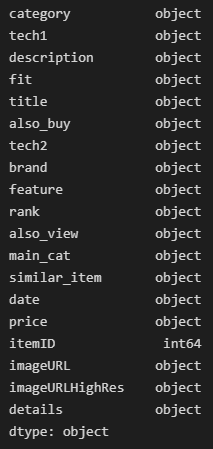




In [55]:
# Ejemplo 1
u_example = 397095
df0 = df_music_instrument["reviewerID"]
count=0
for userID in df0:
    if userID == u_example:
        count+=1
count
print("The userID {u} has {interac} inside the dataset.".format(u=u_example, interac=count))

print("-"*100, end="\n")

# Ejemplo 2
df1 = df_music_instrument.loc[:,["reviewerID", "itemID"]]
df2 = df1[df1.reviewerID != 397095]
print("With a datafram with 2 columns (reviewerID and itemID), we remove the info from the user 397095 which has 506 interactions.")
print("* Initial shape DataFrame 1: {shape1}\n* Final shape after removed info of user {u}: {shape2}\n* shape1[0] - shape2[0] = {info_removed}".format(shape1=df1.shape, u= u_example,shape2=df2.shape, info_removed=df1.shape[0]-df2.shape[0]))

The userID 397095 has 506 inside the dataset.
----------------------------------------------------------------------------------------------------
With a datafram with 2 columns (reviewerID and itemID), we remove the info from the user 397095 which has 506 interactions.
* Initial shape DataFrame 1: (1512530, 2)
* Final shape after removed info of user 397095: (1512024, 2)
* shape1[0] - shape2[0] = 506


In [71]:
def get_values_counts(df, col):
    df_counts = df[col]
    freq = df_counts.value_counts()
    freq_index, freq_counts = freq.index, freq.values
    freq_index.to_numpy()
    return freq_index, freq_counts

th = 5
users = df_music_instrument["reviewerID"]
usersID_freq, interact_freq = get_values_counts(df_music_instrument, "reviewerID")
interact_below_th =  interact_freq[interact_freq < th]
users_below_th = usersID_freq[interact_freq < th] # Array of users below {th = 5} interactions
total_u = max(users)
print("THEORY")
print("Total of users that are below the threshold {th}: {n_users_to_delete} out of {total_users}".format(th=th, n_users_to_delete=len(users_below_th), total_users=total_u))
print("Total of users (updated): {new_total_u}".format(new_total_u=total_u-len(users_below_th)))
print("\nHemos prescindido del {0:.2f}%, de los usuarios.".format(len(users_below_th)/total_u))
print("Interactions inside dataset:")
print("\tInitial interactions: {init}\n\tDeleted interactions: {dele}\n\tRemained interactions: {rem}".format(init=len(users), dele=sum(interact_below_th), rem=len(users)-sum(interact_below_th)))


THEORY
Total of users that are below the threshold 5: 862657 out of 903329
Total of users (updated): 40672

Hemos prescindido del 0.95%, de los usuarios.
Interactions inside dataset:
	Initial interactions: 1512530
	Deleted interactions: 1152891
	Remained interactions: 359639


In [11]:
th = 5
users = df_music_instrument["reviewerID"]
freq_userID = users.value_counts() # see: Ejemplo 1
usersID_freq, interact_freq = freq_userID.index, freq_userID.values
usersID_freq.to_numpy()
print("\nFrecuencia de cuantas veces los usuarios interaccionan a los largo del dataset: \nIndexes\tInteractions")
print(freq_userID)

print("-"*100, end="\n")
interact_below_th =  interact_freq[interact_freq < th]
users_below_th = usersID_freq[interact_freq < th] # Array of users below {th = 5} interactions
total_u = max(users)
print("THEORY")
print("Total of users that are below the threshold {th}: {n_users_to_delete} out of {total_users}".format(th=th, n_users_to_delete=len(users_below_th), total_users=total_u))
print("Total of users (updated): {new_total_u}".format(new_total_u=total_u-len(users_below_th)))
print("\nHemos prescindido del {0:.2f}%, de los usuarios.".format(len(users_below_th)/total_u))
print("Interactions inside dataset:")
print("\n\tInitial interactions: {init}\n\tDeleted interactions: {dele}\n\tRemained interactions: {rem}".format(init=len(users), dele=sum(interact_below_th), rem=len(users)-sum(interact_below_th)))




Frecuencia de cuantas veces los usuarios interaccionan a los largo del dataset: 
Indexes	Interactions
397095    506
690587    275
538090    226
753703    193
806922    151
         ... 
613145      1
871173      1
889713      1
437873      1
592111      1
Name: reviewerID, Length: 903330, dtype: int64
----------------------------------------------------------------------------------------------------
THEORY
Total of users that are below the threshold 5: 862657 out of 903329
Total of users (updated): 40672

Hemos prescindido del 0.95%, de los usuarios.
Interactions inside dataset:
	Initial interactions: 1512530
	Deleted interactions: 1152891
	Remained interactions: 359639


mean del histograma: 8.842204902515181


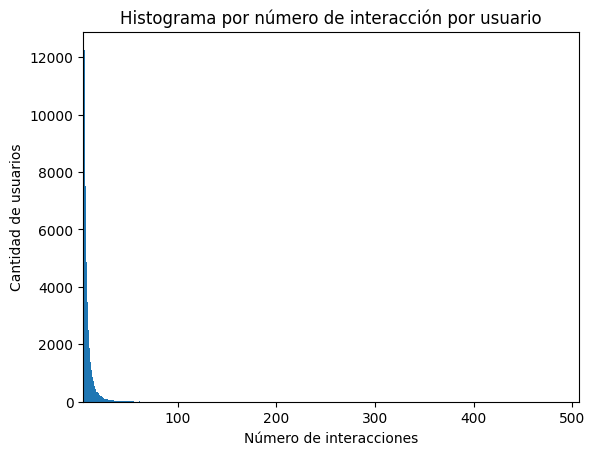

In [46]:
hist =  interact_freq[interact_freq >= th]
mean_user = np.mean(hist)
print("mean del histograma: {}".format(mean_user))
x_minus_lim = min(hist)-1
x_max_lim = max(hist)+1
bins_array = range(min(hist)-1,max(hist)+1)

plt.hist(hist, bins=bins_array)
#plt.xlim(min(hist),20)
plt.xlim(x_minus_lim,x_max_lim)
plt.xlabel("Número de interacciones")
plt.ylabel("Cantidad de usuarios")
plt.title("Histograma por número de interacción por usuario")
plt.savefig("histogram.png")

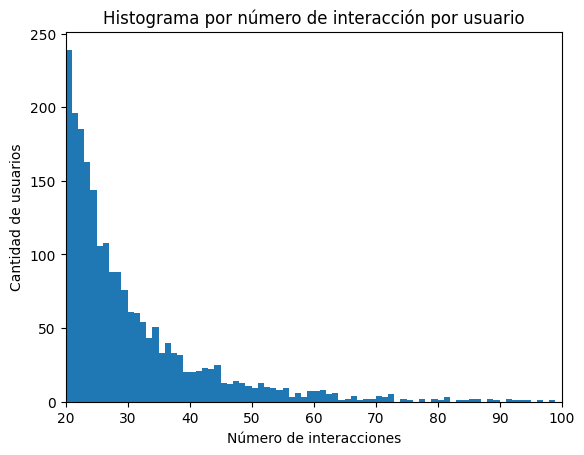

In [54]:
x_minus_lim = 20
x_max_lim = 100
bins_array = range(x_minus_lim,max(hist)+1)
plt.hist(hist, bins=bins_array)
#plt.xlim(min(hist),20)
plt.xlim(x_minus_lim,x_max_lim)
plt.xlabel("Número de interacciones")
plt.ylabel("Cantidad de usuarios")
plt.title("Histograma por número de interacción por usuario")
plt.savefig("histogram_zoom.png")

In [307]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

u = filter_rows_by_values(df_music_instrument, "reviewerID", users_below_th)

874914

In [56]:
df_music_instrument.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'itemID',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')

1456790400    2017
1453248000    1713
1482883200    1670
1483401600    1619
1420243200    1593
              ... 
1166745600       1
1144627200       1
1117843200       1
1125619200       1
1538611200       1
Name: unixReviewTime, Length: 5708, dtype: int64


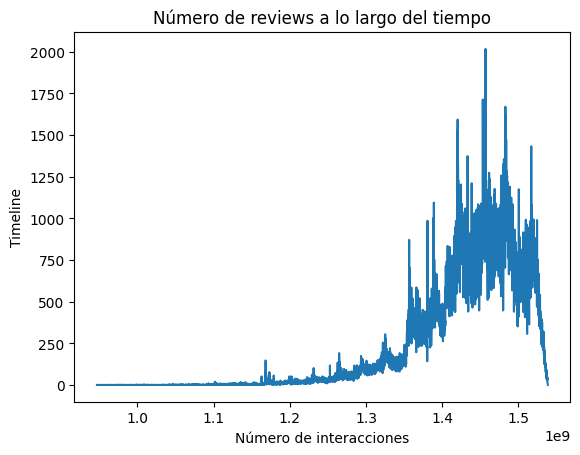

In [66]:
timeline = df_music_instrument["unixReviewTime"]
freq_timeline = timeline.value_counts() # see: Ejemplo 1
print(freq_timeline)
time_freq, inter_time_freq = freq_timeline.index, freq_timeline.values
time_freq.to_numpy()
inter_per_time = inter_time_freq[np.argsort(time_freq)]

plt.plot(np.sort(time_freq),inter_per_time)
plt.xlabel("Número de interacciones")
plt.ylabel("Timeline")
plt.title("Número de reviews a lo largo del tiempo")
plt.savefig("Timeline_zoom.png")

In [17]:
#df_music_instrument["overall"].head()
df_music_instrument.iloc[0] # row 0

overall                                                         5.0
vote                                                           90.0
verified                                                      False
reviewTime                                               08 9, 2004
reviewerID                                                   886861
itemID                                                            5
style                                     {'Format:': ' Paperback'}
reviewerName                                                  Bendy
reviewText        Crocheting for Dummies by Karen Manthey & Susa...
summary               Terrific Book for Learning the Art of Crochet
unixReviewTime                                           1092009600
image                                                           NaN
Name: 0, dtype: object